# General Set Up

## Logging Configuration

In [1]:
import logging

logging.basicConfig(
    format='[%(asctime)s] %(name)s:%(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

## Saving to CSV

In [2]:
from functools import wraps

def cache(method):
    path = Path.cwd() / f"{method.__name__}.csv"

    @wraps(method)
    def wrapper(*args, **kwargs):
        if path.is_file():
            return pd.read_csv(
                path,
                index_col=0, sep=r'\s*,\s*', engine='python'
            )
        
        df = pd.DataFrame(method(*args, **kwargs))

        if not path.parent.is_dir():
            path.parent.mkdir(parents=True)

        df.to_csv(path)

        return df

    return wrapper

# Image Classification


## Loading & Preprocessing

In [3]:
from pathlib import Path

import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder


def get_files(path, extension):
    return Path(path).glob(f'*.{extension}')


def get_images(path, extension='jpg'):
    for filename in get_files(path, extension):
        yield filename, Image.open(filename)


def get_resized_images(path, extension='jpg', size=None):
    for filename, image in get_images(path, extension):
        yield filename, image.resize(size) if size is not None else image

In [4]:
def load_images(path, size=None):
    images, labels = [], []
    for filename, image in get_resized_images(path, size=size):
        images.append(np.ravel(np.asarray(image)))
        labels.append(filename.name[0])

    if size is None and any(len(_) != len(images[0]) for _ in images):
        max_lenth = len(max(images, key=lambda vector: len(vector)))

        _ = np.zeros((len(images), max_lenth), dtype='uint8')
        for index, image in enumerate(images):
            _[index][0:len(image)] = image

        images = _
    else:
        images = np.array(images, dtype='uint8')

    labels = np.array(LabelEncoder().fit_transform(labels))

    return images, labels

In [5]:
def loadImages(path):
    return load_images(path, (100, 100))

In [6]:
data, labels = loadImages('./img')

## PCA & Visualization

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def pca(data, n_components=2):
    normalized = MinMaxScaler().fit_transform(data)

    pca = PCA(n_components=n_components).fit(normalized)

    return pca.transform(normalized), pca.explained_variance_ratio_

In [8]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_image(axes, x, y, image, zoom=0.5):
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)

    axes.add_artist(AnnotationBbox(im, (x, y), xycoords='data'))

    axes.update_datalim(np.column_stack([x, y]))
    axes.autoscale()
    plt.scatter(x, y)

In [9]:
import matplotlib.pyplot as plt

def plot_images(xy, images):
    axes = plt.gca()

    for (x, y), image in zip(xy, images):
        scatter_image(axes, x, y, image)

    plt.title("Principal Component Analysis of Seasonal Images")
    plt.xlabel('Component #1')
    plt.ylabel('Component #2')
    plt.xlim(
            xy[:,0].min() * 1.5,
            xy[:,0].max() * 1.5
    )
    plt.ylim(
            xy[:,1].min() * 1.5,
            xy[:,1].max() * 1.5
    )
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

In [10]:
def PCA_ImageSpaceVisualization(X):
    xy, _ = pca(data)

    images = [
        Image.fromarray(image.reshape(100, 100, 3), 'RGB')
        for image in X
    ]

    plot_images(xy, images)

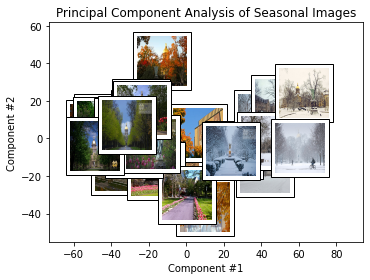

In [11]:
PCA_ImageSpaceVisualization(data)

The previous PCA plot converts the correlations among all the images into a 2D plot.

Images that are highly correlated cluster together, whilst images that are not highly correlated drift apart.

Regarding the example at hand, this observation can be safely generalized for higher dimensions, but this is not always the case. For example, PCA always considers the low variance components in the data as noise, but sometimes those components play a major role.

Every season, and thus every photo corresponding to it, has a distinct **color pallete**. As a result, a large number of pixel values differ only marginally between images taken during the same season. This translates into these images being highly correlated and thus clustering together on the PCA 2D plot.

## Classification using KNN &  SVM

In [12]:
logger = logging.getLogger('KNN_SVM_COMPARISON')

In order to compare the accuracy of the KNN & SVM models regarding the classification of the images we are going to be using the `accuracy_score` function provided by `scikit-learn`, which, as stated in the `scikit-learn` documentation, "in binary and multiclass classification, this function is equal to the `jaccard_score` function."

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient), which examines which members are shared accross two different sets, is given by the following formula

$$J = \frac{\left \| X \bigcap Y \right \|}{\left \| X \bigcup  Y \right \|}$$

where, `X` corresponds to the set of labels, predicted by the model, and `Y` to the set containing the actual labels.

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def kfold_accuracy(model, data, labels, n_splits=5, shuffle=True):
    kfold = KFold(n_splits=n_splits, shuffle=shuffle)

    scores = []
    for train_indices, test_indices in kfold.split(data):
        train_data = data[train_indices]
        train_labels = labels[train_indices]

        model.fit(train_data, train_labels)

        test_data = data[test_indices]
        test_labels = labels[test_indices]

        predict_labels = model.predict(test_data)

        score = accuracy_score(
            test_labels, predict_labels,
            normalize=True
        )

        scores.append(score * 100)

    return sum(scores) / n_splits

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pandas as pd

@cache
def knn_svm_comparison(data, labels, runs, n_components):
    datasets = {
        'original': data,
        'reduced': pca(data, n_components)[0]
    }

    models = {
        'svm': SVC(kernel='linear'),
        'knn': KNeighborsClassifier(n_neighbors=1)
    }

    results = []
    for run in range(runs):
        for model_tag, model in models.items():
            for dataset_tag, dataset in datasets.items():
                logger.info(
                    "Run: %02d, Model: %s, Dataset: %s" % (
                        run, model_tag, dataset_tag
                    )
                )

                score = kfold_accuracy(model, dataset, labels)
                results.append({
                    "Model": model_tag,
                    "Dataset": dataset_tag,
                    "Score": score
                })
    
                logger.info("Score: %05.2f" % (score,))

    return pd.DataFrame(results)

In [15]:
(data, labels) = load_images('./img', size=None)

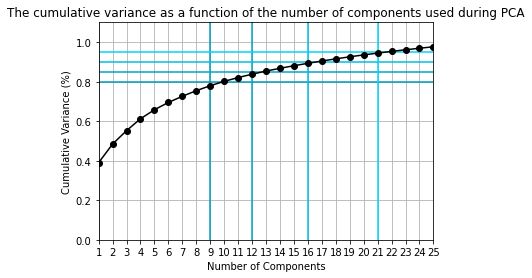

In [16]:
n_components = 25

_, variance = pca(data, n_components=n_components)

x, y = np.arange(1, n_components + 1), np.cumsum(variance)

plt.axhline(y=0.80, color='#009bba', linestyle='-')
plt.axvline(x=np.where(y > 0.80)[0][0], color='#009bba', linestyle='-')

plt.axhline(y=0.85, color='#00a6c7', linestyle='-')
plt.axvline(x=np.where(y > 0.85)[0][0], color='#00a6c7', linestyle='-')

plt.axhline(y=0.90, color='#00bee3', linestyle='-')
plt.axvline(x=np.where(y > 0.90)[0][0], color='#00bee3', linestyle='-')

plt.axhline(y=0.95, color='#03d3fc', linestyle='-')
plt.axvline(x=np.where(y > 0.95)[0][0], color='#03d3fc', linestyle='-')

plt.plot(x, y, marker='o', linestyle='-', color='k')

plt.xlim((1, n_components))
plt.ylim((0, 1.1))

plt.xticks(x)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.title(
    'The cumulative variance '
    'as a function of the number of components used during PCA'
)

plt.grid()
plt.show()

In order to get over **95%** of variance explained, we need **21** principal components.

In [17]:
df = knn_svm_comparison(data, labels, 5, 21)

**Notice:** `scikit-learn` offers a way of automatically determining the number of components required in order to achieve any amount of variance explained.

According to the `scikit-learn` documentation

_If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components._



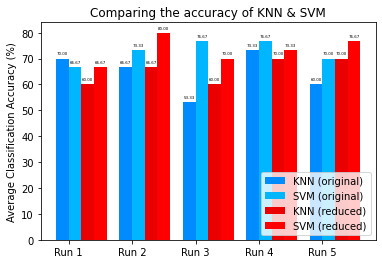

In [18]:
runs = 5

knn_data, svm_data = df[df['Model'] == 'knn'], df[df['Model'] == 'svm']

s1 = knn_data[knn_data['Dataset'] == 'original']['Score']
s2 = svm_data[svm_data['Dataset'] == 'original']['Score']
s3 = knn_data[knn_data['Dataset'] == 'reduced']['Score']
s4 = svm_data[svm_data['Dataset'] == 'reduced']['Score']

indices, w = np.arange(runs), 0.2

c = ['#008cff', '#00b7ff', '#eb0000', '#ff0000']

_, axes = plt.subplots()

p1 = axes.bar(indices + 0 * w, s1, w, color=c[0],label='KNN (original)')
p2 = axes.bar(indices + 1 * w, s2, w, color=c[1],label='SVM (original)')
p3 = axes.bar(indices + 2 * w, s3, w, color=c[2],label='KNN (reduced)')
p4 = axes.bar(indices + 3 * w, s4, w, color=c[3],label='SVM (reduced)')

for barplot in [p1, p2, p3, p4]:
    for bar in barplot:
        height = bar.get_height()
        axes.annotate(
            f'{height:05.2f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=4
        )

axes.set_title('Comparing the accuracy of KNN & SVM')
axes.set_xticks(indices + w / 2)
axes.set_xticklabels([f'Run {run + 1}' for run in range(runs)])
plt.ylabel('Average Classification Accuracy (%)')

axes.legend(loc='lower right')
axes.autoscale_view()
plt.show()


It is clear that the **Linear SVM** model performs better than the 1-NN.

That is to be expected, as we are working with a few points in a high dimensional space and SVM is able to linearly separate them.


# Regularized Non-negative Matrix Factorization

We need to tackle the following problem

$$\min_{W, C}{\left \| X - W \times C\right \|^{2}_{F} + \lambda \cdot \left \| W \right \|^2_{F} + \lambda \cdot \left \| C \right \|^2_{F}}$$

subject to

$$
\begin{align}
W \ge 0 \\
C \ge 0
\end{align}
$$

We are going to be using a `gradient descent` based approach. So we are going to be using the following update rules for `W` and `C`

$$
\begin{align}
C_{[t + 1]} &= C_{[t]} - n_{C_[t]} \cdot \triangledown_{C_{[t]}}l(W, C_{[t]}) \\
W_{[t + 1]} &= W_{[t]} - n_{W_[t]} \cdot \triangledown_{W_{[t]}}l(W_{[t]}, C)
\end{align}
$$

Firstly we calculate the needed derivatives

$$
\begin{align}
\triangledown_{C_{[t]}}l(W, C_{[t]} &= 2 \cdot \lambda \cdot C - 2 \cdot W^T \times (X - W \times C) \\
\triangledown_{W_{[t]}}l(W_{[t]}, C) &= 2 \cdot \lambda \cdot W - 2 \cdot (X - W \times C) \times C^T
\end{align}
$$

We are going to use a data-adaptive learning rate, in order to convert the aforementioned set of additive update rules to an equivalent set of multiplicative update rules.

By doing so, we assert the non-negativity of W & C.

$$
\begin{align}
n_{C_[t]} &= \frac{C}{C \times (\lambda + W^T \times W)} \\
n_{W_[t]} &= \frac{W}{W \times (\lambda + C \times C^T)}
\end{align}
$$

Finally, we plug everything into the additive update formulas.

$$
\begin{align}
C &= C - (\frac{C}{C \times (\lambda + W^T \times W)}) \times (2 \cdot \lambda \cdot C - 2 \cdot W^T \times (X - W \times C)) \Leftrightarrow \\
C &= C * \frac{W^T \times X}{\lambda \cdot C + W^T \times W \times C}
\end{align}
$$

$$
\begin{align}
W &= W - (\frac{W}{W \times (\lambda + C \times C^T)}) \cdot (2 \cdot \lambda \cdot W - 2 \cdot (X - W \times C) \times C^T) \Leftrightarrow \\
W &= W * \frac{W^T \times X}{\lambda \cdot C + W^T \times W \times C}
\end{align}
$$

Having now established any necessary theoretical background, let's proceed with the implementation.

In [19]:
logger = logging.getLogger('NMF')

In [20]:
import numpy as np

def error(X, W, C, l):
    return np.linalg.norm(X - np.dot(W, C)) / np.linalg.norm(X)

    
def get_new_c(X, W, C, l):
    return C * np.divide(np.dot(W.T, X), l * C + np.dot(np.dot(W.T, W), C))


def get_new_w(X, W, C, l):
    return W * np.divide(np.dot(X, C.T), l * W + np.dot(W, np.dot(C, C.T)))

In [21]:
def reg_nmf(X, k=2, l=0, e=1e-12):
    n, m = X.shape
    low, high = X.min(), X.max()

    W = np.random.uniform(low=low, high=high, size=(n, k))
    C = np.random.uniform(low=low, high=high, size=(k, m))

    e_current, e_previous, it = error(X, W, C, l), float('inf'), 0
    while e_previous - e_current >= e:
        if it % 2:
            C = get_new_c(X, W, C, l)
        else:
            W = get_new_w(X, W, C, l)

        e_previous, e_current, it = e_current, error(X, W, C, l), it + 1

    return W, C, it

## Gathering Metrics

In [22]:
@cache
def nmf_convergence(ks, es):
    n, m, low, high = 500, 1000, 0, 1

    X = np.random.uniform(low=low, high=high, size=(n, m))

    columns, data = ['k', 'e', 'Iterations', 'Time'], []

    for k in sorted(ks):
        for e in sorted(es):
            logger.info("k: %d, e: %.1e" % (k, e))
            W, C, iterations = reg_nmf(X, k=k, e=e)
            
            data.append(dict(zip(columns, [k, e, iterations])))

    return pd.DataFrame(data)

In [23]:
ks, es = [1, 10, 100], [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

df = nmf_convergence(ks, es)

In [24]:
def iterations_with_respect_to(field, subset, ratio=False):
    verbose = {
        'e': 'acceptable error margin',
        'k': 'number of components'
    }

    other_field = 'k' if field == 'e' else 'e'
    partial_label = f'{field} = '

    plt.xlim(0, 0)
    plt.ylim(0, 0)

    plt.xscale('log')

    plt.xlabel(other_field.title())

    if ratio is True:
        plt.ylabel('Increase (%)')
    else:
        plt.ylabel('Iterations')

    for value in df[field].unique():
        subset = df[df[field] == value]

        label = partial_label + (f'{value:e}' if field == 'e' else f'{value:d}')

        x, y = subset[other_field], subset['Iterations']

        if ratio is True:
            y = np.array([(y.iloc[i] / y.iloc[i - 1]) * 100 if i - 1 >= 0 else 100 for i in range(len(y))])

        plt.plot(x, y, label=label)

        x_min, x_max = min((x.min(),) + plt.xlim()), max((x.max(),) + plt.xlim())
        if field == 'e':
            plt.xlim(x_min, x_max)
        else:
            plt.xlim(x_max, x_min)

        y_min, y_max = min((y.min() - 1,) + plt.ylim()), max((y.max() + 1,) + plt.ylim())
        plt.ylim(y_min, y_max)

        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.title(
            'The increase (%) in the number of iterations' if ratio is True else 'The number of iterations '
            'as a function of '
            f'the {verbose[other_field]}'
        )

    plt.show()

_Notice:_ The **absolute** and **relative** increase in the number of iterations when using values in the range $ \{ 10^{-1}, \dots, 10^-{3} \} $ is insignificantly small and we were not able to draw any interesting conclusions regarding the convergence of the algorithm.

In order to tackle this issue, we are going to be using values in the range $ \{ 10^{-1}, \dots, 10^{-9} \} $ for `e`.

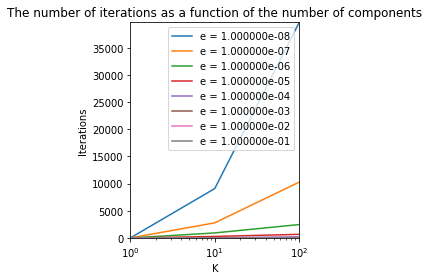

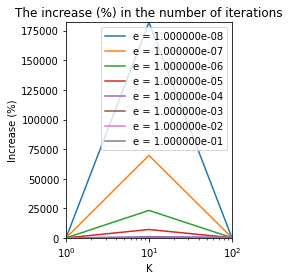

In [25]:
plt.subplot(1, 2, 1)
iterations_with_respect_to('e', df)
plt.subplot(1, 2, 2)
iterations_with_respect_to('e', df, ratio=True)

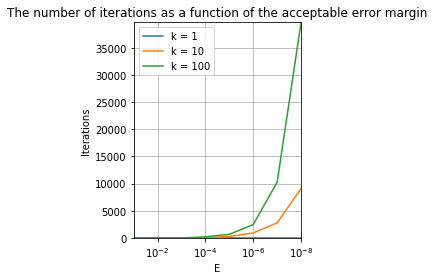

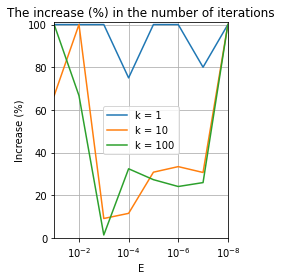

In [26]:
plt.subplot(1, 2, 1)
iterations_with_respect_to('k', df)
plt.subplot(1, 2, 2)
iterations_with_respect_to('k', df, ratio=True)

As expected, decreasing either the `e` or the `k` meta-parameter, whilst keeping the other fixed, results in a greater number of iterations, as more computation is needed in order to reach the desired acceptable error margin.